In [1]:
import glob
import mne
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import re
from scipy import signal
import os

In [2]:
'''
read the EEG data from the files
check if you nead to update path
'''
files_eeg_b= glob.glob(r"C:\Users\yehuda\pain_of_payment\Data_PoP\mindMonitor_*_b_*.csv", recursive= False)

# sort the data files by subject number
regex = re.compile(r'\d+')
files_eeg_b.sort(key=lambda x: int(regex.findall(x)[-1]))

# note - the EEG measurments fron quationarie are not proccessed here. in previous "firt filter try" version
# files_eeg_q = glob.glob(r"C:\Users\yehuda\pain_of_payment\Data_PoP\mindMonitor_*_q_*.csv", recursive= False)  #to delete
# files_eeg_q.sort(key=lambda x: int(regex.findall(x)[-1])) #to delete

In [3]:
'''
read the quastionarie data from the files
check if you nead to update path
'''
# read the questionarie payment information
questionarie = pd.read_excel(r"C:\Users\yehuda\pain_of_payment\Pain of Payment Questionnaire.xlsx",\
                             usecols = ['Payment_method'], sheet_name='Sheet0')


In [4]:
'''
initialize global variables
'''
freq_bands = dict(delta=(0.1,4), theta=(4,7), alpha=(8,15), beta=(16,31), gamma=(32,100))

# create info about the EEG expieremrnt
ch_names = ['EEG_channels']
ch_types = ['eeg']
sfreq = 256
info = mne.create_info(ch_names = ch_names, ch_types=ch_types, sfreq = sfreq)

In [5]:
def save_file(file_name, df_data, data_type, bool=False):
    # create folder named output if it doesn't exists
    folder_name = 'output_' + data_type
    file_name = file_name + ".csv"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    # save data to the file inside folder
    file_path = os.path.join(folder_name, file_name)
    df_data.to_csv(file_path, index=bool, encoding = 'utf-8-sig')

In [6]:
'''
reading EEG measurements from the ToB + time_frame_start until ToB + time_frame_end
using only the data from RAW_AF7 and RAW_AF8 electtrodes
'''
def read_b_data(file, time_frame_start, time_frame_end, time_frame_str):
    
    # read data drom file
    df_data = pd.read_csv(file, low_memory=False, usecols = ['TimeStamp','RAW_AF7','RAW_AF8','ToB'])
    
    # adjust the time frame to be from ToB + time_frame_start until ToB + time_frame_end
    ToB = pd.to_timedelta(df_data["ToB"].loc[0])
    if time_frame_start < 0:
        start = ToB - pd.to_timedelta("0:0:0" + str(abs(time_frame_start)))
    else:
        start = ToB + pd.to_timedelta("0:0:0" + str(time_frame_start))
    if time_frame_end < 0:
        end = ToB - pd.to_timedelta("0:0:0" + str(abs(time_frame_end)))
    else:
        end = ToB + pd.to_timedelta("0:0:0" + str(time_frame_end))
    
    df_data["TimeStamp"] = pd.to_timedelta(df_data["TimeStamp"])
    df_RawEEG = df_data[(df_data["TimeStamp"] <= end) & (df_data["TimeStamp"] >= start)].copy()
    
    # use only the RAW_AF7 and RAW_AF8 series
    df_RawEEG.drop(["ToB", "TimeStamp"], inplace = True, axis=1)
    
    #optional - to save to csv
#     save_file("df_RawEEG" + time_frame_str, df_RawEEG, 'b')
    
    return df_RawEEG

In [7]:
'''
adjust the data from RAW_AF7 and RAW_AF8 electtrodes:
1) remove (mark as invalid) RAW_AF<x> data if there are more than 15% zeroes
2) do detrend 
3) do interpolation: for nan values and for data that is more than the 2xstd (standard deviation) 
4) take the mean between RAW_AF7 and RAW_AF8 (if both are valid), or only one (if one is valid), or None (if both are unvalid) 
'''
def adjust_data(df_data, time_frame_str, data_type):
    
    # Drop from df_data rows with all NaN values
    df_data.dropna(how='all', inplace = True)
    
    # check if there are less than 20% zeroes in electrode data
    RAW_AF7_valid = ((df_data['RAW_AF7'] == 0).sum()) / (len(df_data['RAW_AF7'])) < 0.15
    RAW_AF8_valid = ((df_data['RAW_AF8'] == 0).sum()) / (len(df_data['RAW_AF8'])) < 0.15
    
    # remove column if it was marked as invalid data
    if not RAW_AF7_valid:
        df_data.drop('RAW_AF7', axis = 1, inplace= True)
    if not RAW_AF8_valid:
        df_data.drop('RAW_AF8', axis = 1, inplace= True)
    if not RAW_AF7_valid and not RAW_AF8_valid:
        return None
    
    # replace zero values with NaN
    df_data.replace(to_replace=0, value=np.nan, inplace=True)
    
    # detrend the EEG signal for non-NaN values
    for col in df_data.columns:
        # Boolean mask for non-NaN values
        mask = ~np.isnan(df_data[col])
        # Apply detrend only on non-NaN values
        signal.detrend(df_data.loc[mask, col], overwrite_data = True)
    
    # Interpolate missing values using the default linear method.
    # limit_direction='both' to to allow interpolation to the first and last values.
    # may - to check if limit is needed. if it is 1 it causes problems because of nan values
    df_data.interpolate(limit_direction='both', inplace=True)
    
    # interpolate values that exceed 2 std for using the default linear method.
    for col in df_data.columns:
        mean = df_data[col].mean()
        std = df_data[col].std()
        outliers = (df_data[col] > mean + 2*std) | (df_data[col] < mean - 2*std)
        df_data.loc[outliers, col] = np.nan
        # may - to check if limit is needed- if it is 1 it causes problems because of nan values
        df_data[col].interpolate(limit_direction='both', inplace=True)
    
    # take the mean between of the valid columns
    EEG_channels = pd.Series(df_data.mean(axis=1))
    
    # use only the EEG_channels serie
    df_cleaned_RawEEG = pd.DataFrame(EEG_channels, columns=['EEG_channels'])
    
    # optional - to save to csv
#     save_file("df_cleaned_RawEEG" +  time_frame_str, df_cleaned_RawEEG, data_type)

    return df_cleaned_RawEEG

In [8]:
'''
Analyzing the EEG data:
calculate Power Spectral Density
'''
def PSD(df_data, time_frame_str, data_type):
    df_data = df_data.transpose()
    raw = mne.io.RawArray(df_data, info)
    raw.filter(l_freq = 1, h_freq = 100, picks = 'eeg')  #to check if needed- method = 'iir'
    #raw.notch_filter(freqs=50, picks = 'eeg') - to check if needed
    
    # calculate Power Spectral Density 
    psd = raw.compute_psd(method = 'welch', picks = ['EEG_channels'])
    
    df_psd = psd.to_data_frame()
    
    # filter to frequancies between 0.1-100Hz
    df_PSD = df_psd[(df_psd["freq"]<=100) & (df_psd["freq"]>=0.1)]
    
    # optional - to save to csv
#     save_file("df_PSD" +  time_frame_str, df_PSD, data_type)
    
    return df_PSD

In [9]:
'''
calculate the mean of each wave band: delta, theta, alpha,beta, gama 
'''
def wave_bands(psd_df):
    
    columns = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    subject_data={}
    i=0
    
    for wave, wave_range in freq_bands.items():
        wave_band = (psd_df[(psd_df['freq'] >= wave_range[0]) & (psd_df['freq'] <= wave_range[1])]['EEG_channels']).mean()
        subject_data[columns[i]] = [wave_band]
        i += 1
        
    df_bands = pd.DataFrame(subject_data)
    
    return df_bands

In [10]:
# remove subjects that their average exceed 4 std from the average of all participants wave
# to delete
def filter_subjects2(df_data):
    df_data_filtered = df_data.copy()
    columns = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    for wave in columns:
        mean = df_data_filtered[wave].mean()
        std = df_data_filtered[wave].std()
        print("mean in ", wave, "is ", mean)
        print("std in ", wave, "is ", std)
        df_data_filtered = df_data_filtered[(df_data_filtered[wave] <= (mean + 4*std)) & (df_data_filtered[wave] >= (mean - 4*std))]
    return df_data_filtered

In [11]:
'''
MAIN function to proccess the EEG_b data
proccessing to each subject its EEG data from the ToB + time_frame_start until ToB + time_frame_end
'''
def calculate_EEG_features(time_frame_start, time_frame_end, time_frame_str):

    # initilaize variables
    num_subject = 1
    df_all_subjects_bands = pd.DataFrame()

    for file in files_eeg_b:

        # read the relevant data from Muse results 
        df_RawEEG = read_b_data(file, time_frame_start, time_frame_end, time_frame_str)

        # adjust and filter the EEG data
        df_cleaned_RawEEG = adjust_data(df_RawEEG, time_frame_str, 'b')
        if df_cleaned_RawEEG is None:
            print ("num_subject ", num_subject, "was removed")
            num_subject += 1
            continue

        # calculate Power Spectral Density
        df_PSD = PSD(df_cleaned_RawEEG, time_frame_str, 'b')

        # seperate to frequacies bands (waves) and calculate the mean for each wave
        df_bands =  wave_bands(df_PSD)

        # add subject number 
        df_bands['subject'] = num_subject

        # add current subject data to all the data that was collected so far
        df_all_subjects_bands = pd.concat([df_all_subjects_bands, df_bands])

        num_subject += 1

    # optional - to save to csv
    save_file("df_all_subjects_bands" + time_frame_str, df_all_subjects_bands, 'b')
    
    return df_all_subjects_bands

In [12]:
def calculate_painOfPayment_score():
    pass

In [13]:
def calculate_payment_amount():
    pass

In [14]:
def calculate_payment_method():
    #  payment information
    questionarie_payment = questionarie['Payment_method'].drop(0)
    questionarie_payment = questionarie_payment.rename_axis('subject').reset_index()
    return questionarie_payment

In [15]:
def merge_all(EEG_features, painOfPayment, paymentAmount, paymentMethod):
    df_merged = pd.merge(EEG_features, painOfPayment, on="subject", how="inner")
    df_merged = pd.merge(df_merged, paymentAmount, on="subject", how="inner")
    df_merged = pd.merge(df_merged, paymentMethod, on="subject", how="inner")
    return df_merged

In [16]:
'''
calculate the mean power of each wave-band as a function of payment method
and display the results
for each time frame
'''
def based_payment(df_data, time_frame_str, data_type):
    df_based_payment = df_data.groupby('Payment_method').mean().drop(labels='subject', axis=1)

    # optional - to save to csv
    save_file("df_psd_based_payment" + time_frame_str, df_based_payment, data_type, True)
    
    return df_based_payment

In [17]:
# create a bar plot of the average power in each frequency band for each payment method
def my_plot(df_data, time_frame_str):
    
    ax = df_data.transpose().plot(kind='bar', figsize=(10, 6), rot=0, fontsize=10, y=['Cash', 'Credit Card', 'Smartphone'])

    # set the axis labels and title
    ax.set_xlabel('frequacy band', fontsize=12)
    ax.set_ylabel('Power', fontsize=12)
    title = 'Average Power by frequacy band and payment method ' + time_frame_str
    ax.set_title(title, fontsize=14)

    # display the plot
    plt.rcParams['font.family'] = 'Arial'
    plt.show()

In [18]:
# to may - continue here

def analyze(EEG_features, painOfPayment, paymentAmount, paymentMethod, time_frame_str):
    # calculate the mean power of each wave-band as a function of payment method
    df_wave_based_payment = pd.merge(EEG_features, paymentMethod, on="subject", how="inner")
    wave_mean_based_payment = based_payment(df_wave_based_payment, time_frame_str, 'b')
    my_plot(wave_mean_based_payment, time_frame_str)
    
    # calculate the mean power of each wave-band as a function of pain of payment score
    

    # plot the average power in each frequency band for each payment method
    
    

Creating RawArray with float64 data, n_channels=1, n_times=1032
    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1032
    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1020
    Range : 0 ... 1019 =      0.000 ...     3.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1032
    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1020
    Range : 0 ... 1019 =      0.000 ...     3.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1031
    Range : 0 ... 1030 =      0.000 ...     4.023 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1032
    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1020
    Range : 0 ... 1019 =      0.000 ...     3.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1020
    Range : 0 ... 1019 =      0.000 ...     3.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1032
    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1020
    Range : 0 ... 1019 =      0.000 ...     3.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1026
    Range : 0 ... 1025 =      0.000 ...     4.004 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1020
    Range : 0 ... 1019 =      0.000 ...     3.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1026
    Range : 0 ... 1025 =      0.000 ...     4.004 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1020
    Range : 0 ... 1019 =      0.000 ...     3.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1025
    Range : 0 ... 1024 =      0.000 ...     4.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=999
    Range : 0 ... 998 =      0.000 ...     3.898 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1044
    Range : 0 ... 1043 =      0.000 ...     4.074 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1032


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1008
    Range : 0 ... 1007 =      0.000 ...     3.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1032
    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1032
    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1032
    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1032
    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
num_subject  27 was removed


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1023
    Range : 0 ... 1022 =      0.000 ...     3.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1032
    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1008
    Range : 0 ... 1007 =      0.000 ...     3.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1034
    Range : 0 ... 1033 =      0.000 ...     4.035 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1010
    Range : 0 ... 1009 =      0.000 ...     3.941 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1021
    Range : 0 ... 1020 =      0.000 ...     3.984 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1068
    Range : 0 ... 1067 =      0.000 ...     4.168 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1008
    Range : 0 ... 1007 =      0.000 ...     3.934 secs
Ready.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1030
    Range : 0 ... 1029 =      0.000 ...     4.020 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1008
    Range : 0 ... 1007 =      0.000 ...     3.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1032


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1025


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 1024 =      0.000 ...     4.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1008
    Range : 0 ... 1007 =      0.000 ...     3.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=991
    Range : 0 ... 990 =      0.000 ...     3.867 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a on

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1012
    Range : 0 ... 1011 =      0.000 ...     3.949 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1034
    Range : 0 ... 1033 =      0.000 ...     4.035 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1014
    Range : 0 ... 1013 =      0.000 ...     3.957 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1008
    Range : 0 ... 1007 =      0.000 ...     3.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1042
    Range : 0 ... 1041 =      0.000 ...     4.066 secs
Ready.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1031
    Range : 0 ... 1030 =      0.000 ...     4.023 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1020
    Range : 0 ... 1019 =      0.000 ...     3.980 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=988
    Range : 0 ... 987 =      0.000 ...     3.855 secs
Ready.
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1008
    Range : 0 ... 1007 =      0.000 ...     3.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1008
    Range : 0 ... 1007 =      0.000 ...     3.934 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=996


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Range : 0 ... 995 =      0.000 ...     3.887 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)
Creating RawArray with float64 data, n_channels=1, n_times=1044
    Range : 0 ... 1043 =      0.000 ...     4.074 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=1, n_times=1032
    Range : 0 ... 1031 =      0.000 ...     4.027 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 845 samples (3.301 sec)

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


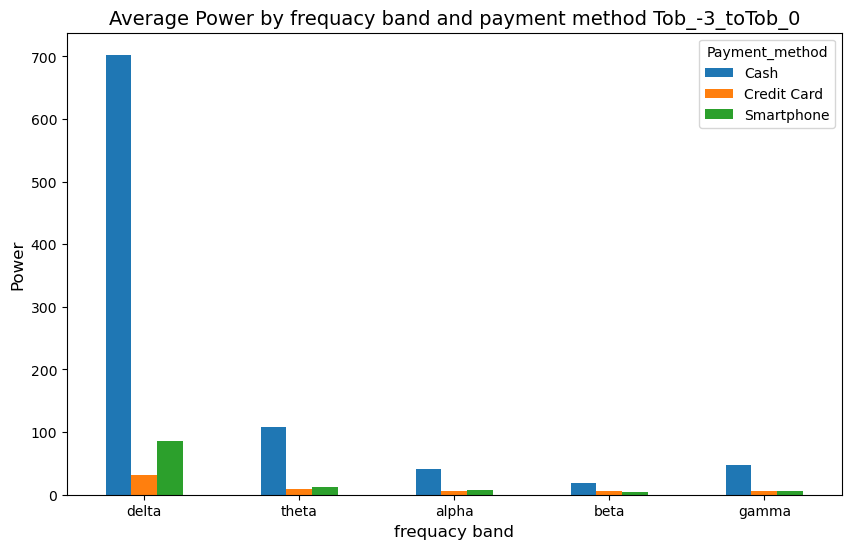

In [19]:
'''
MAIN function
'''
# change the time frames as needed: from ToB + time_frame_start until ToB + time_frame_end
# note: time_frame_start and time_frame_end must be between -9 to 9 (included)
time_frame_start = -3 
time_frame_end = 0
time_frame_str = "Tob_" + str(time_frame_start) + "_toTob_" + str(time_frame_end)

# A data frame that contains EEG data to all valid subjects: for each wave (delta, theta, alpha,beta, gama) its average power
EEG_features = calculate_EEG_features(time_frame_start, time_frame_end, time_frame_str)

# A data frame that contains to all subjects their pain of payment score 
painOfPayment = calculate_painOfPayment_score()

# A data frame that contains to all subjects their amount of payment
paymentAmount = calculate_payment_amount()

# A data frame that contains to all subjects their type of payment
paymentMethod = calculate_payment_method()

# Create a data frame that contains all the data
# All_data = merge_all(EEG_features, painOfPayment, paymentAmount, paymentMethod)

# optional - to save to csv
# save_file("df_all_subjects_data_" + time_frame_str, All_data, 'b')

# Analyze the data
analyze(EEG_features, painOfPayment, paymentAmount, paymentMethod, time_frame_str)

# Model 1 (first question): Tries to predict the payment method based on the EEG_features and painOfPayment?

# Model 2 (second question) : Tries to predict the painOfPayment score based on the EEG_features

# Model 3 (thies question) :  Tries to predict the payment amount based on the EEG_features